In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Read data from file

In [302]:
data = pd.read_csv('rent_data_ready_for_ml.csv', index_col=0)

## Pre-process the data

The data is already processed after our previous phase. However, there are things we can do to improve the training process with this data, is to reduce the magnitute of the price number. For now, they are all number of over 6 digits, which could make the calculation process slower. Let's try to reduce that by changing the metric from `vnd` to `million vnd`. 

In [303]:
data['Price'] = data['Price'] / 1000000
data.rename({'Price': 'Price (million vnd)'}, inplace=True)

We also need to do is to remove the `Post data` column as we won't be using that for trainint.

In [304]:
data.drop(['Post date'], axis=1, inplace=True)

The data is now ready for training. For our model, we'll be focusing on predicting the price of `Căn hộ chung cư` property. 

In [305]:
data = data[data['Rent type'] == 'Căn hộ chung cư']

#### Detect outliner in the data

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

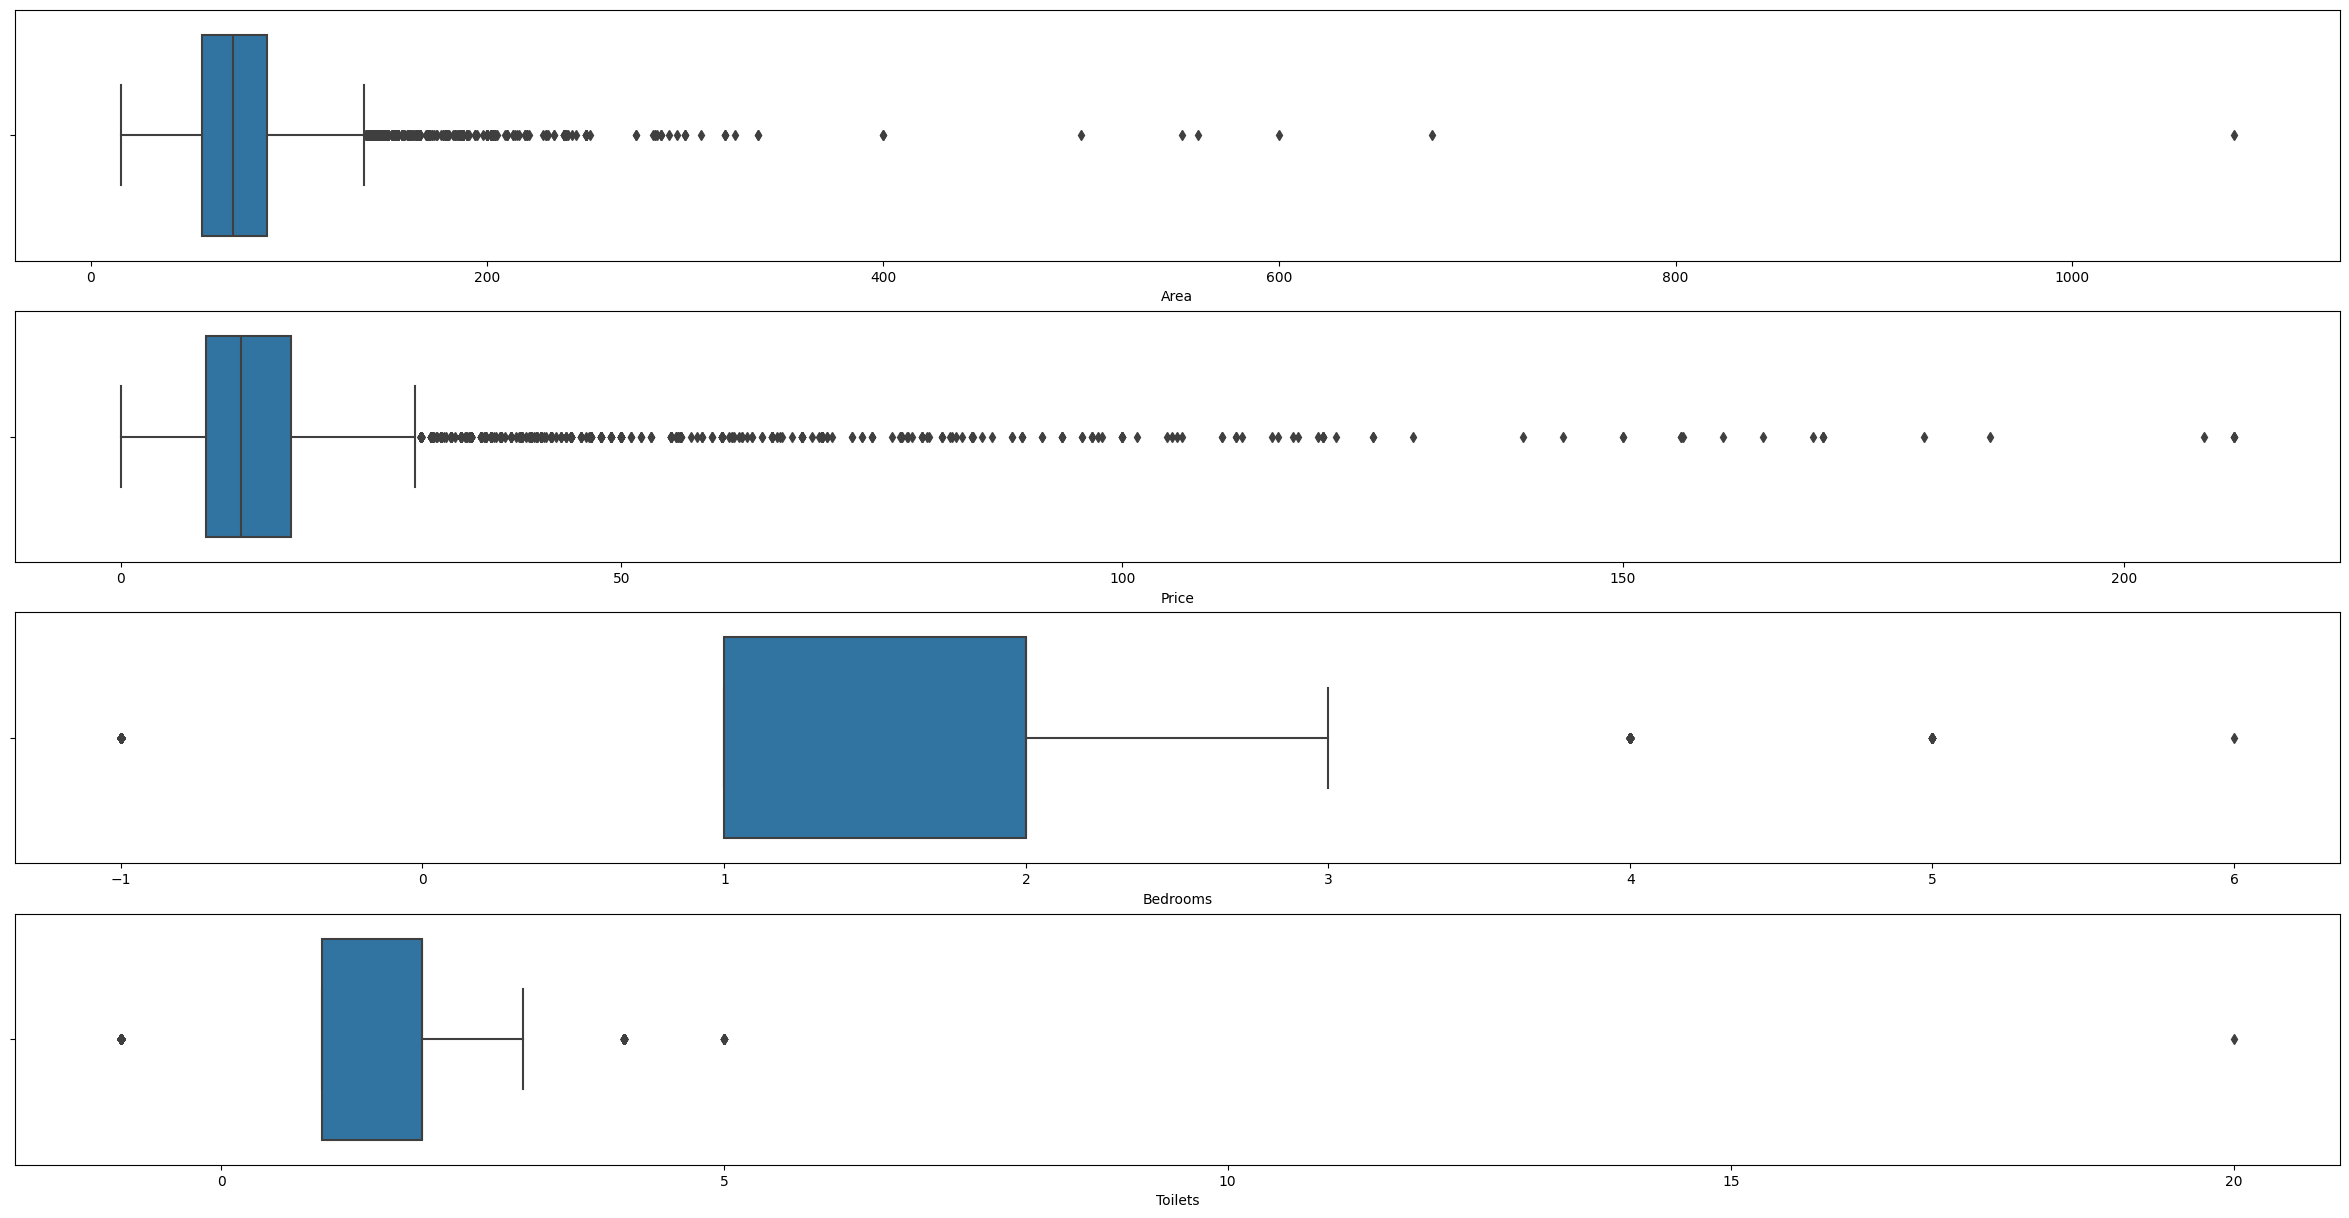

In [306]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

As we can see, there is a lot of outliner in all of the fields. 

Let's assume that the outliner are valid and not due to insertion error in the dataset. I'll keep the data as is becuase I believe the outliner is relevance in our training. 

## Model builing

Since we are building a regression model, there are several models we can choose from:
- Linear Regression
- Ridge Regression
- Lasso Regression
- ElasticNet Regression
- Decision Tree Regression
- Random Forest Regression

We wil be using Cross Value Validation to pick the best between the models. But before that, let's dive a little deeper into what we will be working with to understand our process better.

### 1. How to evaluate the models - what metrics we are using

First, let's explore what metrics we are using to evaluate our models. For regression models, we typically use the following metrics:
- Mean Absolute Error (MAE): Average of absolute differences betweens predictions and actual values.
- Mean Squared Error (MSE): Average of squared differences between predictions and actual values.
- Root Mean Squared Error (RMSE): Square roots of MSE. 
- R-squared (Coefficient of Determination): Measure the proportion of variance in the dependent variable that is predictable from the independent variables. 

For our analysis, we're be using MAE and RMSE to understand the prediction error in term of our price unit (which is million VND) and R-quare to understand how well our model explain the variance in the housing price. We will also be measure the time it takes to run each model (cost of time).

I'd like to take some time to talk a bit more about R-square since it might be a bit difficult to understand at first. The formula for R-square is:

${Var(mean) - Var(fit) \over Var(mean)}$


Where `Var(mean)` describe the distribution of data points around their mean, while `Var(fit)` describe the distribution of the data points around the regression line. To explain how R-square work, let's imagine 2 senarios. 

1. If all the points falls in the regression line:

In this senario, the `Var(mean)` would have a value which we will call V, but `Var(fit)` wil have a value of 0. Because all the predicted data points fall on the regression line, the distance from every points to the regression line (and that also mean model - regression line can make perfect prediction). 

In this case, the value of R-square would be 1. Because:

${Var(mean) - Var(fit) \over Var(mean)}$ = $Var(mean) - 0 \over Var(mean)$ = 1

Which we can interpret as the dependent variable is perfected explained by the independent variables.

2. If no points fall in the regression line

Let's pretend like there is a senario where the distance of the variables to the regression line is the same as the distance to the mean of the data set. This regression line must be a very bad model because it does no better job than the mean line of the data set. 

In this case, the values of R-square would be 0. Because: 

${Var(mean) - Var(fit) \over Var(mean)}$ = $Var(mean) -  Var(mean) \over Var(mean)$ = 0

Which we can interpret as the dependent can't be explained by(and have no correlation with) the independent variables at all.

**In conclusion**: the way we are interpreting R-square is how much the dependent variable (value we want to predict) can be explain with the independent variable (values we use to predict). It values can range from 0 to 1 (although the value can also be negitive but I'm not going to dive into the reason why).


### 2. How do each model works

#### Multiple Linear Regression

The multiple linear regression is linear regression apply to multiple dimension (depends on the number of predictors in our analysis).

$$Y = β0​+β1​X1​+β2​X2​+β3​X3​+⋯+βp​Xp​+ε$$

Where:

- Y is the dependent variable (the variable being predicted). 
- X1, X2, X3,…, Xp ​ are the independent variables (predictors). 
- β0​ is the intercept (constant term). 
- β1, β2, β3,…, βp ​ are the coefficients or slopes that represent the effect of each independent variable on the dependent variable. 
- ε represents the error term, capturing the difference between the actual and predicted values.

The main ideas of multiple linear regression is pretty much the same as linear regression, where we're trying to minimize Mean Squared Error (MSE) for the final regression line.

#### Ridge Regression

Ridge regression is another type of regression, where instead of finding the regression that best fit the test data, the model a penalty term to the Least Square method.

By doing this, the models aim to minimize the sum of squared residuals while also penalizing large coefficients, which could mitigate the problem of overfitting.

The formula for Ridge Regression is:

$$\sum_{i=1}^{n} ​(yi​−β0​−β1*​xi1​−β2*​xi2​−⋯−βp​*xip​)^2 + λ*\sum_{j=1}^{p} (βj^2) $$

Where:
- yi is the observed value of the dependent variable.
- xi1, xi2,…, xip​ are the independent variables.
- β0, β1,…, βp are the coefficients being estimated.
- p is the number of predictors.
- n is the number of observe data points.
- λ is the regularization parameter (the hyperparameter of this model) that determine the strength of the penalty term.

This regression is very similar to Lasso Regression as we will see below. Ridge regression is effective in situations where many predictors are relevent.

#### Lasso Regression

Lasso Regression is very similar to Ridge Regression as we will see with their formular. The only different is that instead of squaring the slope, Lasso use the absolute value of the slope. 

The difference between Ridge and Lasso Regression is that Ridge regression can shrink values of parameter but never be equal to 0. With Lasso Regression, irrelevant parameter can be shrink to 0 and will be exluded from the calculation.

The formula for Lasso Regression is:

$$\sum_{i=1}^{n} ​(yi​−β0​−β1*​xi1​−β2*​xi2​−⋯−βp​*xip​)^2 + λ*\sum_{j=1}^{p} (|βj|) $$

Where:
- yi is the observed value of the dependent variable.
- xi1, xi2,…, xip​ are the independent variables.
- β0, β1,…, βp are the coefficients being estimated.
- p is the number of predictors.
- n is the number of observe data points.
- λ is the regularization parameter (the hyperparameter of this model) that determine the strength of the penalty term.

Ridge regression is effective in situations where are many predictors but only a subset of them might be relevent.


#### ElasticNet Regression

ElasticNet Regression a hybrid regularization technique that combines penalties from both Lasso (L1 regularization) and Ridge (L2 regularization) regression methods. It aims to overcome the limitations of each method by providing a compromise between L1 and L2 regularization.

The formula for Lasso Regression is:

$$\sum_{i=1}^{n} ​(yi​−β0​−β1*​xi1​−β2*​xi2​−⋯−βp​*xip​)^2 + λ1*\sum_{j=1}^{p} (|βj|) + λ2*\sum_{j=1}^{p} (βj^2) $$

Where:
- yi is the observed value of the dependent variable.
- xi1, xi2,…, xip​ are the independent variables.
- β0, β1,…, βp are the coefficients being estimated.
- p is the number of predictors.
- n is the number of observe data points.
- λ is the regularization parameter (the hyperparameter of this model) that determine the strength of the penalty term.

ElasticNet regression is a versatile technique that combines the strengths of Lasso and Ridge regularization methods, offering flexibility in handling multicollinearity, feature selection, and model complexity in linear regression settings.

With that said, ElasticNet Regression has some short comming, include:
- High computational complexity
- Difficulty in fine-tunning parameters
- Less effective in highly sparse or dense data (sparse dataset where most predictors are irrelevant is better trained with Lasso Regression, and dense data set where large number of highly correlated predictors is better trained with Ridge Regression).

#### Decision Tree Regression

Decision tree regression is a non-parametric supervised learning method used for regression tasks, which employ a tree structure to do predict continuous numeric values.

A tree regression works by using a tree structure - a hierarchical tree-like structure consist of nodes and branches. Each internal node represents a test on an attribute, and each branch represent an outcome of the test. The predicted continuous values is in the leaf nodes.

With each predictors, the decision tree algorithm selects the best features and optimal thresholds to split the dataset at each node - optimal being minimizing the variance of the target variable within the resulting subset after split.

If working with many predictors, the Decision Tree Regression create decision trees for all predictors, and pick the candidate with smallest sum of squared residuals to be the root, and contininue to split observations into smaller group.

Spliting is very important in Decision Tree Regression as it determine the ability to classify observations into optermal threshold. Usually, we can effect the slitting process by tunning the hyperparameters (maximum depth, minimum samples per leaf, minimum samples per split) of algorithm.

Decision Tree Regression has a lot advantages:
- Interpretability: It is easy to interpret and visualize.
- Handling Non-linearity: It can capture non-linear relationhips between features and the target variable.

But Decision Tree Regression also has some limitations:
- Overfitting: Decision trees are prone to overfiting when tree depth is too deep or sample per leaf is to few.

#### Random Forest Regression

#### 1. Multiple linear regression model

In [307]:
# Prepare our data
x = data.loc[:, ['Area', 'Bedrooms', 'Toilets','Floors', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']]
y = data['Price']

In [308]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.22, random_state=41)

In [309]:
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [310]:
y_pred_train = model.predict(x_train)

0.5151534891535835


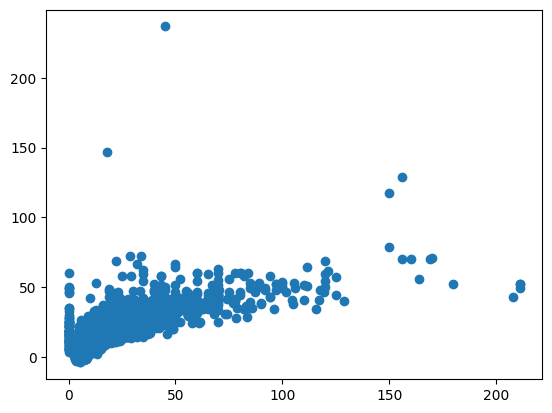

In [311]:
plt.scatter(y_train, y_pred_train)
print(r2_score(y_train, y_pred_train))

0.6390931319038186


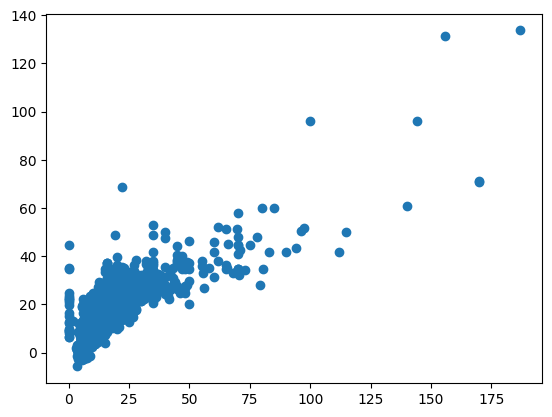

In [312]:
y_pred_test = model.predict(x_test)
print(r2_score(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test)


### 2. Ridge Regression

Best hyperparameters: {'alpha': 0.19}
Test set R-squared: 0.6391084548548256


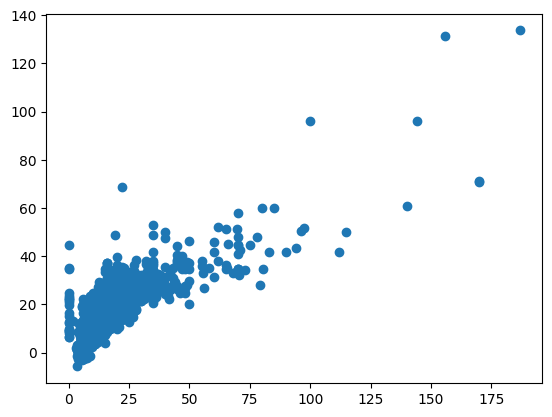

In [313]:
# Create the model
model = Ridge()

# Define the hyperparameter grid
param_grid = {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}

# Perform GridSearchCV with cross-validation (5-fold in this case)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the final model using the best hyperparameters on the entire training dataset
best_model = Ridge(**best_params)
best_model.fit(x_train, y_train)

y_predict = best_model.predict(x_test)

# Evaluate the final model on the test set
test_score = best_model.score(x_test, y_test)
print(f"Test set R-squared: {test_score}")

plt.scatter(y_test, y_predict)

### 3. Lasso regression

Best hyperparameters: {'alpha': 0.1}
Test set R2: 0.6260873144683912


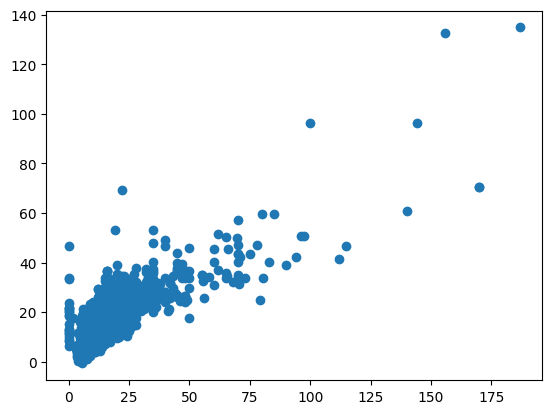

In [314]:

# Create the Lasso Regression model
lasso_model = Lasso()

# Define the hyperparameter grid for alpha values to search through
param_grid = {'alpha': [0.1, 1, 10, 100]}  # Define a list of alpha values to try

# Perform GridSearchCV with cross-validation (5-fold in this case)
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the final model using the best hyperparameters on the entire training dataset
best_model = Lasso(**best_params)
best_model.fit(x_train, y_train)

# Evaluate the final model on the test set
y_pred = best_model.predict(x_test)
test_mse = r2_score(y_test, y_pred)
print(f"Test set R2: {test_mse}")

plt.scatter(y_test, y_pred)


### 4. ElasticNet Regression

Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 1}
Test set R2: 0.6260873144683912


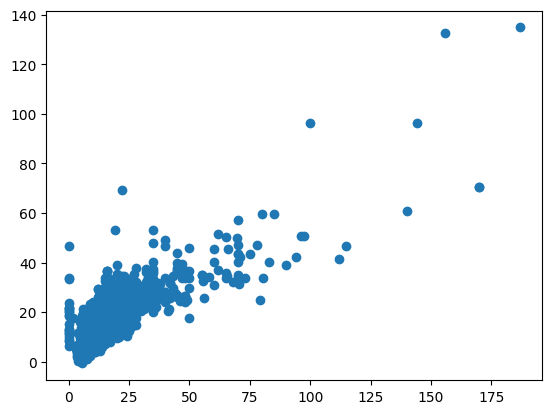

In [315]:
# Create the ElasticNet Regression model
elasticnet_model = ElasticNet()

# Define the hyperparameter grid for alpha and l1_ratio values to search through
param_grid = {'alpha': [0.1, 1, 10], 'l1_ratio': [0.3, 0.7, 1]}  # Define a grid of alpha and l1_ratio values

# Perform GridSearchCV with cross-validation (5-fold in this case)
grid_search = GridSearchCV(elasticnet_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the final model using the best hyperparameters on the entire training dataset
best_model = ElasticNet(**best_params)
best_model.fit(x_train, y_train)

# Evaluate the final model on the test set
y_pred = best_model.predict(x_test)
test_mse = r2_score(y_test, y_pred)
print(f"Test set R2: {test_mse}")

plt.scatter(y_test, y_pred)


### 5. Decision Tree Regression

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Test set Mean Squared Error (MSE): 0.6847989030908834


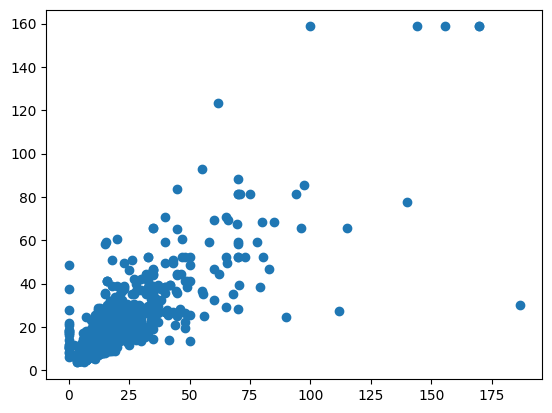

In [319]:
# Create the Decision Tree Regression model
tree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV with cross-validation (5-fold in this case)
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the final model using the best hyperparameters on the entire training dataset
best_model = DecisionTreeRegressor(**best_params)
best_model.fit(x_train, y_train)

# Evaluate the final model on the test set
y_pred = best_model.predict(x_test)
test_mse = r2_score(y_test, y_pred)
print(f"Test set Mean Squared Error (MSE): {test_mse}")

plt.scatter(y_test, y_pred)


### 6. Random Forest Regression

In [317]:
# Create the Random Forest Regression model
forest_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [3, 5, 7, None],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Perform GridSearchCV with cross-validation (5-fold in this case)
grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the final model using the best hyperparameters on the entire training dataset
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(x_train, y_train)

# Evaluate the final model on the test set
y_pred = best_model.predict(x_test)
test_mse = r2_score(y_test, y_pred)
print(f"Test set Mean Squared Error (MSE): {test_mse}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Test set Mean Squared Error (MSE): 0.7021891648034643


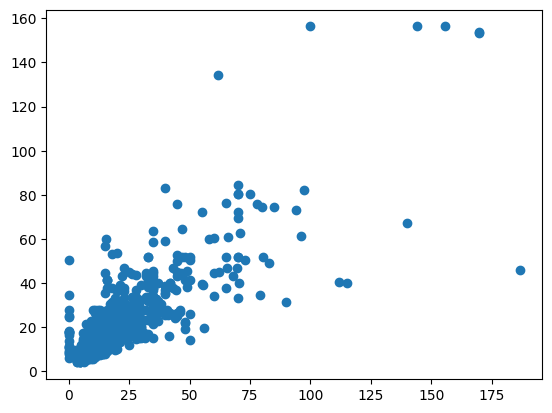

In [318]:
plt.scatter(y_test, y_pred)
